# Predicting Bike Rentals 
by Nicholas Archambault

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day. 

The data was compiled into a file containing 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. 

Columns include:

   * `instant` - A unique sequential ID number for each row
   * `dteday` - The date of the rentals
   * `season` - The season in which the rentals occurred
   * `yr` - The year the rentals occurred
   * `mnth` - The month the rentals occurred
   * `hr` - The hour the rentals occurred
   * `holiday` - Whether or not the day was a holiday
   * `weekday` - The day of the week (as a number, 0 to 7)
   * `workingday` - Whether or not the day was a working day
   * `weathersit` - The weather (as a categorical variable)
   * `temp` - The temperature, on a 0-1 scale
   * `atemp` - The adjusted temperature
   * `hum` - The humidity, on a 0-1 scale
   * `windspeed` - The wind speed, on a 0-1 scale
   * `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
   * `registered` - The number of registered riders (people who had already signed up)
   * `cnt` - The total number of bike rentals (casual + registered)

This project will attempt to predict the total number of bikes rented in a given hour using a variety of machine learning models. The `cnt` column will serve as the target, and features will include all other columns besides `casual` and `registered`.

## Import Packages and Examine Data

We can first read in the data and explore it using the usual techniques. A quick histogram plot of the `cnt` column reveals a right-skewed distribution of rental data. Examining inter-column correlation gives us a rough sense of how closely each column is related to one another.

In [1]:
# Import packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bikes = pd.read_csv("bike_rental_hour.csv")
bikes.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

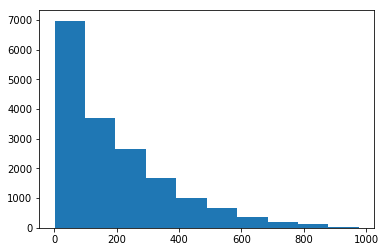

In [3]:
plt.hist(bikes["cnt"])

In [4]:
bikes.corr().iloc[:,-1] # Eliminate the `instant` column

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

## Engineering Features

The `hr` column shows which hour, from 1 to 24, a bike was rented, but it does not understand that certain hours are related. We can group 'morning', 'afternoon', 'evening', and 'night' hours together with a simple function.

In [5]:
def assign_label(hour):
    hour = int(hour)
    
    # 'Night' hours
    if 0 <= hour and hour < 6:
        return 4
    
    # 'Evening' hours
    elif 6 <= hour and hour < 12:
        return 1
    
    # 'Afternoon' hours
    elif 12 <= hour and hour < 18:
        return 2
    
    # 'Morning' hours
    elif 18 <= hour < 24:
        return 3
    
bikes["time_label"] = bikes["hr"].apply(assign_label)

## Training and Testing

Prior to training and testing our data with a variety of model types, we must choose an error metric appropriate to the target column. We see that `cnt` consists of continuous, numeric data; accordingly, mean squared error (MSE) seems to be the best choice of metric by which to evaluate this data.

Nest, we assign 80% of our data as the training dataset, and the other 20% as the test dataset.

In [6]:
train = bikes.sample(frac=0.8)

In [7]:
bikes["intrain"] = bikes.index.isin(train.index) # Creates a binary variable showing whether row is in training data

In [8]:
test = bikes[bikes["intrain"] == False] # Partitions data into test set

We'll drop the columns that we've identified to be ineffectual for prediction, as well the target column, `cnt`, and those columns that we've replaced, such as `hr`.

In [9]:
columns = bikes.columns.drop(["cnt", "casual", "dteday", "registered", "intrain", "hr", "instant"]).tolist()

From here, we can begin fitting different models and comparing their errors to find the best choice.

### Linear Regression

In [10]:
# Import packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Instantiate and fit linear regression model
lr = LinearRegression()
lr.fit(train[columns], train["cnt"])
predictions = lr.predict(test[columns])
mse = mean_squared_error(predictions, test["cnt"])

In [11]:
mse

19973.800903282583

Given that many of the columns are highly correlated, we would expect linear regression to render a fairly accurate model. The error, however, is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

### Decision Tree

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are prone to instability -- small changes in the input data can result in a very different output model.

In [12]:
# Import packages
from sklearn.tree import DecisionTreeRegressor

# Instantiate and fit decision tree
reg = DecisionTreeRegressor()
reg.fit(train[columns], train["cnt"])
predictions_tree = reg.predict(test[columns])
mse_tree = mean_squared_error(predictions_tree, test["cnt"])

In [13]:
mse_tree

22697.315360887354

Our first iteration of a decision tree actually returns an error higher than that of the linear regression model, indicating that it may be overfitting. Tweaking parameters within the model, including the number of minimum samples per leaf, can lead to a better model.

In [14]:
# Update parameters and re-fit
reg = DecisionTreeRegressor(min_samples_leaf = 5)
reg.fit(train[columns], train["cnt"])
predictions_tree = reg.predict(test[columns])
mse_tree = mean_squared_error(predictions_tree, test["cnt"])
print(mse_tree)

16184.591404772305


We observe a vast improvement when the tree model takes into account non-linear predictors.

### Random Forest

Finally, we can apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, so it's important to tune parameters like maximum depth and minimum samples per leaf.

This time, we'll plot the errors of random forests of varying minimum samples per leaf in order to see how they change as the parameter is altered.

In [26]:
# Import packages
from sklearn.ensemble import RandomForestRegressor

# Iterate over random forest models with varying minimum samples per leaf
vals = []
for i in range(1,22):
    rf = RandomForestRegressor(min_samples_leaf = i)
    rf.fit(train[columns], train["cnt"])
    predictions_forest = rf.predict(test[columns])
    mse_forest = mean_squared_error(predictions_forest, test["cnt"])
    vals.append(mse_forest)

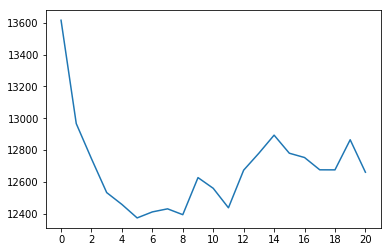

In [27]:
# Plot data to visually examine which parameter tuning renders least error
plt.plot(vals)
plt.xticks(range(0,22,2))
plt.show()

In [28]:
# Identify the index of the model with the least error. Run model
rf = RandomForestRegressor(min_samples_leaf = vals.index(min(vals)))
rf.fit(train[columns], train["cnt"])
predictions_forest = rf.predict(test[columns])
mse_forest = mean_squared_error(predictions_forest, test["cnt"])
print(mse_forest)

12296.859751905602


We set the minimum samples per leaf to the value between 1 and 20 that renders the most accurate model. Using list indexing, and confirmed by visual inspection of the plot, we find that value to be 5. Indeed, the best random forest model improves on the error of the decision tree model.

Next steps could include further random forest parameter tuning to drive the error even lower.

## Conclusion

In this project, we predicted the number of bikes rented at a given hour in Washington D.C. and compared the accuracies of linear regression, decision tree, and random forest algorithms, finding that random forests yielded the best-fitting predictive model as measured by lowest mean squared error.